#0. Importing libraries

In [1]:
# Install packages
!pip install chembl_webresource_client
!pip install rdkit
!pip install mols2grid

  Using cached attrs-21.4.0-py2.py3-none-any.whl (60 kB)
  Attempting uninstall: attrs
    Found existing installation: attrs 23.1.0
    Uninstalling attrs-23.1.0:
      Successfully uninstalled attrs-23.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jsonschema 4.19.1 requires attrs>=22.2.0, but you have attrs 21.4.0 which is incompatible.
referencing 0.30.2 requires attrs>=22.2.0, but you have attrs 21.4.0 which is incompatible.
  Using cached attrs-23.1.0-py3-none-any.whl (61 kB)
  Attempting uninstall: attrs
    Found existing installation: attrs 21.4.0
    Uninstalling attrs-21.4.0:
      Successfully uninstalled attrs-21.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests-cache 0.7.5 requires attrs<22.0,>=21.2, but yo

In [2]:
from chembl_webresource_client.new_client import new_client

In [3]:
import pandas as pd
import numpy as np

# I. Reading of Data

In [13]:
# Make a query in Chembl database to find activities agains D2 dopsmine receptor
target = new_client.target
activity = new_client.activity
D2 = target.filter(target_chembl_id='CHEMBL217')
D2_activities = activity.filter(target_chembl_id='CHEMBL217')

In [14]:
df = pd.DataFrame(D2_activities)

In [6]:
df.to_csv('D2_activities.csv')

NameError: ignored

In [4]:
from rdkit import Chem #RDKit Chemistry
from rdkit.Chem.Draw import IPythonConsole #RDKit drawing
from rdkit.Chem import Draw #RDKit drawing
# A few settings to improve the quality of structures
from rdkit.Chem import rdDepictor
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem import PandasTools #Add the ability to add a molecule to a dataframegrid
import mols2grid #The mols2grid library provides a convenient way of displaying molecules in a grid

In [5]:
# Mounting google drive to save dataframe to csv, because conversint Chembl query to dataframe is to time consumint to do it every time we re-run runtime
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
df = pd.read_csv('/content/drive/MyDrive/D2_activities.csv')

#II. Preparing datasets

In [81]:
# Convert column to dictionary
df['activity_properties'] = df['activity_properties'].apply(lambda x: eval(x))
# Create dataframe from the column and join to the initial dataframe
df = df.join(pd.DataFrame(df['activity_properties'].to_list()))
# Drop the old column
df = df.drop('activity_properties', axis=1)

In [82]:
# List all columns
df.columns

Index([               'Unnamed: 0',               'action_type',
                'activity_comment',               'activity_id',
                 'assay_chembl_id',         'assay_description',
                      'assay_type',   'assay_variant_accession',
          'assay_variant_mutation',              'bao_endpoint',
                      'bao_format',                 'bao_label',
                'canonical_smiles',     'data_validity_comment',
       'data_validity_description',        'document_chembl_id',
                'document_journal',             'document_year',
               'ligand_efficiency',        'molecule_chembl_id',
              'molecule_pref_name', 'parent_molecule_chembl_id',
                   'pchembl_value',       'potential_duplicate',
                      'qudt_units',                 'record_id',
                        'relation',                    'src_id',
                   'standard_flag',         'standard_relation',
             'standard_te

In [83]:
# Drop columns we don't need
df = df.drop(['Unnamed: 0', 'action_type', 'activity_comment', 'activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',   'assay_variant_accession',
              'assay_variant_mutation', 'bao_endpoint', 'bao_format', 'bao_label', 'data_validity_comment', 'data_validity_description', 'document_chembl_id',
              'document_journal', 'document_year', 'ligand_efficiency', 'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate',
              'qudt_units', 'record_id', 'src_id', 'standard_flag', 'standard_relation', 'standard_text_value', 'standard_type', 'standard_units', 'standard_upper_value',
              'standard_value', 'target_tax_id', 'text_value', 'toid', 'uo_units', 'upper_value',  0, 1, 2, 3, 4], axis = 1)

In [84]:
# Print left columns
df.columns

Index(['canonical_smiles', 'molecule_chembl_id', 'relation',
       'target_chembl_id', 'target_organism', 'target_pref_name', 'type',
       'units', 'value'],
      dtype='object')

In [85]:
# Drop none values
df.dropna(subset=['relation','units','type','value'], how='any', inplace=True)

In [86]:
# See how many null value we have in smiles column
df.canonical_smiles.isnull().sum()

15

In [87]:
# 15 is not a lot we can drop
df.dropna(subset=['canonical_smiles'], how='any', inplace=True)

In [88]:
# Choose only Ki values
df = df[df['type'] == 'Ki']

In [89]:
# Left measurment units only from allowed list
allowed_list = ['nM',"10'-9M"]
df = df[df['units'].isin(allowed_list)]

In [90]:
df = df.drop(df[df['value'] < 0].index)

In [91]:
# I want to separate dataframe to two dataframe, first we will use to build a regression model (only records with '=' relation). And another dataframe for
# classification, where we will give label 1 to strong ingibitors (Ki < limit) and weak ingibitors (Ki > limit)

In [92]:
limit = 500

In [93]:
# Explore values with '>' realation. Values with '>' and '>=' erlations with values < limit we can not classify as weak or strong
condition1 = df['relation'].isin(['>','>='])
condition2 = df['value'] < limit
df[condition1 & condition2]

,canonical_smiles,molecule_chembl_id,relation,target_chembl_id,target_organism,target_pref_name,type,units,value
151,CCCN1CCC[C@@H](c2cccc(OS(=O)(=O)c3ccc(C)cc3)c2)C1,CHEMBL92630,>,CHEMBL217,Homo sapiens,Dopamine D2 receptor,Ki,nM,217.0
154,CCCN1CCC[C@@H](c2cccc(NS(=O)(=O)C(F)(F)F)c2)C1,CHEMBL93254,>,CHEMBL217,Homo sapiens,Dopamine D2 receptor,Ki,nM,217.0
155,CCCN1CCC[C@@H](c2cccc(S(C)(=O)=O)c2)C1,CHEMBL311730,>,CHEMBL217,Homo sapiens,Dopamine D2 receptor,Ki,nM,217.0
157,C=CCN1CC[C@@H]2c3cccc(OC)c3CC[C@@H]21,CHEMBL566970,>,CHEMBL217,Homo sapiens,Dopamine D2 receptor,Ki,nM,217.0
158,C=CCN1CC[C@@H]2c3cccc(OC)c3CC[C@@H]21,CHEMBL566970,>,CHEMBL217,Homo sapiens,Dopamine D2 receptor,Ki,nM,339.0
...,...,...,...,...,...,...,...,...,...
6365,COc1cccc(N2CCN(CCCCNC(=O)c3ccc4nonc4c3)CC2)c1,CHEMBL458554,>,CHEMBL217,Homo sapiens,Dopamine D2 receptor,Ki,nM,100.0
6366,COc1ccc(N2CCN(CCCCNC(=O)c3ccc(-n4ccnc4)cc3)CC2...,CHEMBL457974,>,CHEMBL217,Homo sapiens,Dopamine D2 receptor,Ki,nM,100.0
6367,COc1ccc(N2CCN(CCCCNC(=O)c3ccc4nonc4c3)CC2)cc1,CHEMBL447907,>,CHEMBL217,Homo sapiens,Dopamine D2 receptor,Ki,nM,100.0
6371,O=C(NCCCCN1CCN(c2cccc(OCCF)c2)CC1)c1ccc2nonc2c1,CHEMBL458759,>,CHEMBL217,Homo sapiens,Dopamine D2 receptor,Ki,nM,100.0


In [94]:
df = df.drop(df[condition1 & condition2].index)

In [95]:
# Explore values with '<' realation. We can give label strong to all this records
df[df['relation'] == '<']

,canonical_smiles,molecule_chembl_id,relation,target_chembl_id,target_organism,target_pref_name,type,units,value
1258,CCCN1CC[C@H]2c3c(O)cccc3CC[C@H]21,CHEMBL430332,<,CHEMBL217,Homo sapiens,Dopamine D2 receptor,Ki,nM,50.0
6197,CC(C)Oc1ccccc1N1CCN(Cc2cccc(C(=O)N3CCCCC3)c2)CC1,CHEMBL10085,<,CHEMBL217,Homo sapiens,Dopamine D2 receptor,Ki,nM,4.0
12583,Cc1cc2c(s1)Nc1ccccc1N=C2N1CCN(C)CC1,CHEMBL715,<,CHEMBL217,Homo sapiens,Dopamine D2 receptor,Ki,nM,10.0


In [96]:
# Create dataframe for regression
df_regression = df[df['relation']=='=']

In [97]:
# Create dataframe for classification
df_classification = pd.DataFrame()
grouped = df.groupby('relation')
for name, group in grouped:
  if name in ['=','~']:
    group['activity'] = np.where(group['value'] < limit, 1, 0)
  elif name in ['>','>=']:
    group['activity'] = 0
  elif name in ['<']:
    group['activity'] = 1
  df_classification = pd.concat([df_classification, group])

In [98]:
df_regression = df_regression.drop(['molecule_chembl_id', 'relation', 	'target_chembl_id', 'target_organism', 	'target_pref_name', 	'type', 	'units'], axis=1)

In [99]:
PandasTools.RenderImagesInAllDataFrames(images=True)
PandasTools.AddMoleculeColumnToFrame(df_regression, smilesCol='canonical_smiles')

In [100]:
df_classification = df_classification.drop(['molecule_chembl_id', 'relation', 	'target_chembl_id', 'target_organism',
                                            'target_pref_name', 	'type', 	'units', 'value'], axis=1)

In [101]:
PandasTools.AddMoleculeColumnToFrame(df_classification, smilesCol='canonical_smiles')

,canonical_smiles,value,ROMol
2,NC(=O)[C@H]1CS[C@@H]2CC[C@]3(CCCN3C(=O)[C@@H]3...,0.067,
3,NC(=O)[C@H]1CS[C@@H]2CC[C@]3(CCCN3C(=O)[C@@H]3...,190.000,
6,NC(=O)[C@H]1CS[C@@H]2CC[C@]3(CCCN3C(=O)[C@@H]3...,0.196,
7,NC(=O)[C@H]1CS[C@@H]2CC[C@]3(CCCN3C(=O)[C@@H]3...,260.000,
10,NC(=O)[C@H]1CS[C@@H]2CC[C@]3(CCCN3C(=O)[C@@H]3...,0.050,
...,...,...,...
22034,CN1CCN(C(=O)C(C)(C)c2ccc(C(=O)Nc3cn4cc(-c5cc(C...,2752.000,
22035,O=C(NNS(=O)(=O)c1ccccc1F)c1cc(F)cc(-c2ccccn2)c1,397.520,
22036,CCN1CCCC1CNC(=O)c1cc(S(N)(=O)=O)ccc1OC,9.800,
22037,O=C1C2C3CCC(C3)C2C(=O)N1CC1CCCCC1CN1CCN(c2nsc3...,1.700,

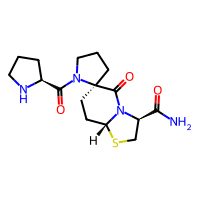
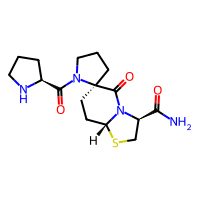
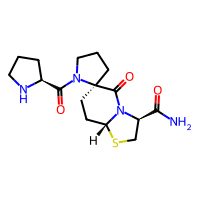
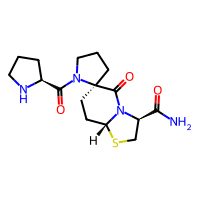
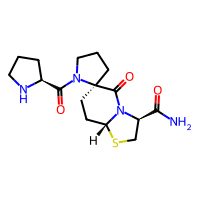
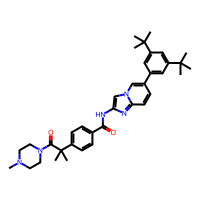
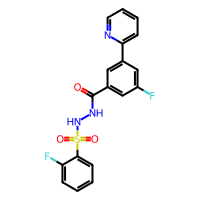
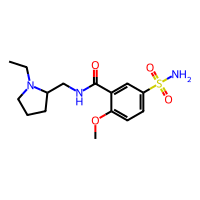
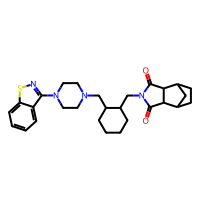
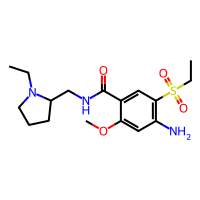

In [102]:
df_regression

,canonical_smiles,activity,ROMol
1258,CCCN1CC[C@H]2c3c(O)cccc3CC[C@H]21,1,
6197,CC(C)Oc1ccccc1N1CCN(Cc2cccc(C(=O)N3CCCCC3)c2)CC1,1,
12583,Cc1cc2c(s1)Nc1ccccc1N=C2N1CCN(C)CC1,1,
2,NC(=O)[C@H]1CS[C@@H]2CC[C@]3(CCCN3C(=O)[C@@H]3...,1,
3,NC(=O)[C@H]1CS[C@@H]2CC[C@]3(CCCN3C(=O)[C@@H]3...,1,
...,...,...,...
22018,Clc1cccc(N2CCNCC2)c1,0,
7609,O=C(Cc1ccccc1)NC1CCN(CCCN2C(=O)COc3ccccc32)CC1,0,
7611,O=C(Cc1ccccc1)NC1CCN(CCCN2C(=O)COc3ccccc32)CC1,0,
7612,CCCCC1CCN(CCCC(=O)c2ccccc2C)CC1,0,

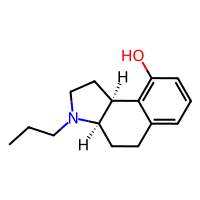
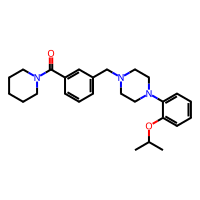
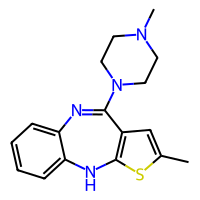
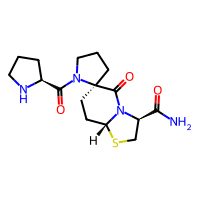
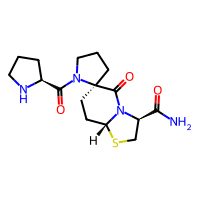
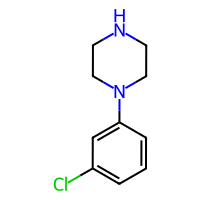
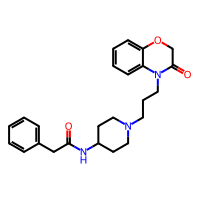
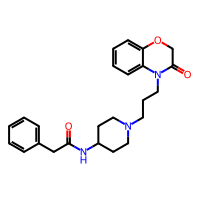
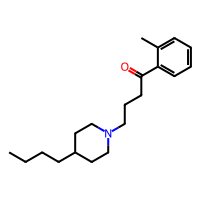
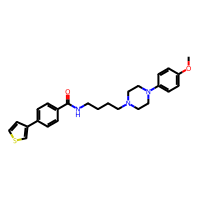

In [103]:
df_classification

# III. Standardizing the structures and removing duplicates


In [104]:
!pip install molvs

In [105]:
from molvs import Standardizer
from rdkit.Chem import SaltRemover
s = Standardizer()

In [106]:
df_regression['ROMol'] = df_regression['ROMol'].apply(lambda x: SaltRemover.SaltRemover().StripMol(s.standardize(x)))
df_regression['SMILES'] = df_regression['ROMol'].apply(lambda x: Chem.MolToSmiles(x, isomericSmiles=True))
df_regression = df_regression.drop('canonical_smiles', axis=1)

In [107]:
df_classification['ROMol'] = df_classification['ROMol'].apply(lambda x: SaltRemover.SaltRemover().StripMol(s.standardize(x)))
df_classification['SMILES'] = df_classification['ROMol'].apply(lambda x: Chem.MolToSmiles(x, isomericSmiles=True))
df_classification = df_classification.drop('canonical_smiles', axis=1)

In [108]:
df_regression = df_regression.sort_values('value')

In [109]:
# Dropping duplicates:

In [110]:
print(len(df_regression))
df_regression = df_regression.drop_duplicates(subset='SMILES', keep='first')
print(len(df_regression))

7593
5746


In [111]:
print(len(df_classification))
df_classification = df_classification.drop_duplicates(subset='SMILES',keep='first')
print(len(df_classification))

8329
6416


<Axes: xlabel='activity'>

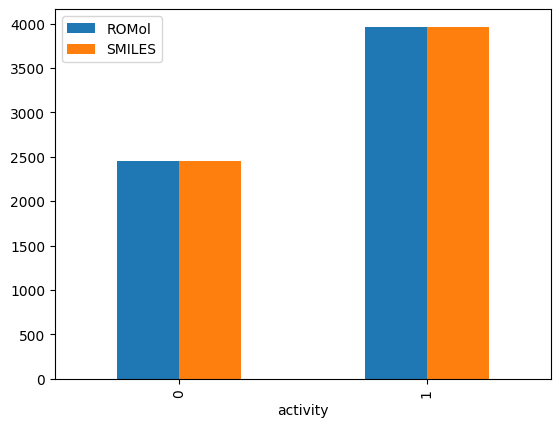

In [112]:
# We have much more active than inactive molecules in our dataset
df_classification.groupby('activity').count().plot(kind='bar')

#IV Generate Morgan fingerprints for classification dataset


In [113]:
from rdkit.Chem import AllChem

In [114]:
morgan_fingerprints = [np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)) for mol in df_classification['ROMol']]
# Convert the list of fingerprints into a NumPy array
morgan_fingerprints_array = np.vstack(morgan_fingerprints)

In [115]:
morgan_fingerprints_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [116]:
labels = np.array(df_classification['activity'])
labels = labels.reshape(-1, 1)

In [117]:
labels

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [118]:
data = np.hstack((morgan_fingerprints_array, labels))

In [119]:
# Randomly shuffle the rows
np.random.shuffle(data)

In [46]:
data

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0]])

#V. Neural network for binary classification

In [47]:
import tensorflow as tf
import sklearn
from tensorflow.keras import layers, models

In [48]:
from sklearn.model_selection import train_test_split
X = data[:, :-1]
y = data[:, -1]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [49]:
model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(2048,)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', input_shape=(2048,)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Output layer with one neuron and sigmoid activation for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
141/141 [==============================] - 3s 13ms/step - loss: 0.5875 - accuracy: 0.6771 - val_loss: 0.4611 - val_accuracy: 0.7890
Epoch 2/30
141/141 [==============================] - 2s 13ms/step - loss: 0.4286 - accuracy: 0.7965 - val_loss: 0.4202 - val_accuracy: 0.8150
Epoch 3/30
141/141 [==============================] - 2s 16ms/step - loss: 0.3626 - accuracy: 0.8406 - val_loss: 0.3943 - val_accuracy: 0.8264
Epoch 4/30
141/141 [==============================] - 2s 16ms/step - loss: 0.3278 - accuracy: 0.8579 - val_loss: 0.4070 - val_accuracy: 0.8181
Epoch 5/30
141/141 [==============================] - 2s 11ms/step - loss: 0.2851 - accuracy: 0.8800 - val_loss: 0.3980 - val_accuracy: 0.8358
Epoch 6/30
141/141 [==============================] - 2s 11ms/step - loss: 0.2496 - accuracy: 0.8942 - val_loss: 0.4038 - val_accuracy: 0.8285
Epoch 7/30
141/141 [==============================] - 2s 12ms/step - loss: 0.2304 - accuracy: 0.9051 - val_loss: 0.4022 - val_accuracy: 0.8295

In [51]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)

31/31 [==============================] - 0s 3ms/step - loss: 1.0504 - accuracy: 0.8172


In [52]:
# Make predictions
predictions = model.predict(X_test)

# Convert probabilities to class labels
predicted_labels = (predictions > 0.5).astype('int32')
predicted_labels.reshape(1,-1)

31/31 [==============================] - 0s 3ms/step


array([[1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy = balanced_accuracy_score(y_test, predicted_labels)
cm = confusion_matrix(y_test, predicted_labels)

In [54]:
print(balanced_accuracy)
print(cm)

0.8021372611902688
[[270  95]
 [ 81 517]]


#VI. Virtual screening on small dataset


In [134]:
with open('45770.smiles.txt', 'r') as file:
  lines = [line.rstrip() for line in file]

In [135]:
df = pd.DataFrame(lines)

In [136]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol=0)

[13:20:12] Explicit valence for atom # 2 N, 4, is greater than permitted
[13:20:12] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:20:12] Explicit valence for atom # 1 O, 3, is greater than permitted
[13:20:12] Explicit valence for atom # 7 N, 4, is greater than permitted
[13:20:12] Explicit valence for atom # 4 C, 5, is greater than permitted
[13:20:12] Explicit valence for atom # 1 F, 3, is greater than permitted
[13:20:12] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:20:13] Explicit valence for atom # 0 N, 5, is greater than permitted
[13:20:14] Explicit valence for atom # 5 H, 2, is greater than permitted
[13:20:16] Explicit valence for atom # 1 N, 5, is greater than permitted
[13:20:17] Explicit valence for atom # 13 N, 5, is greater than permitted
[13:20:19] Explicit valence for atom # 2 N, 5, is greater than permitted
[13:20:19] Explicit valence for atom # 0 N, 5, is greater than permitted


In [137]:
df = df.dropna(how='any')

In [138]:
morgan_fingerprints = [np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)) for mol in df['ROMol']]
# Convert the list of fingerprints into a NumPy array
morgan_fingerprints_array = np.vstack(morgan_fingerprints)

In [139]:
morgan_fingerprints_array.shape

(45757, 2048)

In [140]:
# Make predictions
predictions = model.predict(morgan_fingerprints_array)

# Convert probabilities to class labels
predicted_labels = (predictions > 0.5).astype('int32')

1430/1430 [==============================] - 4s 3ms/step


In [141]:
df['label'] = predicted_labels

,0,ROMol,label
0,C1(=S)SC=CS1,,1
1,O1C2OOC(C1)CC2,,1
4,P1(=O)(CCN1C)N,,1
5,C1CCCN(CC1)N,,1
6,O1P(=O)(CCC1)C,,1
...,...,...,...
45758,N1C(=O)C2C[S+](C3=C(CC(C(=O)NCC(=O)NCC(=O)NCC(...,,1
45761,N1C(=O)C2NC(=O)CNC(=O)CNC(=O)CCSSCCNC(=O)CNC(=...,,1
45765,C1(=O)N2C(C(=O)N3C(C(=O)NCC(=O)N(CCCCCCCCCC=CC...,,1
45766,O=C1NCC(=O)NCC(=O)NCC(=O)N(CC(=O)N(CC(=O)NCC(=...,,1

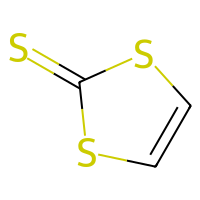
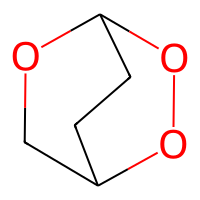
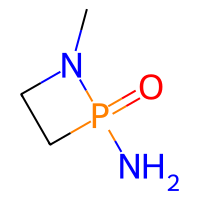
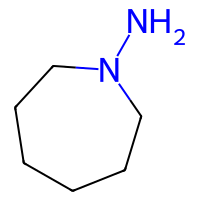
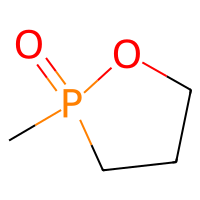
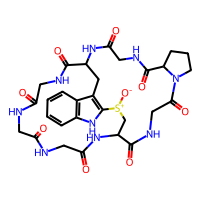
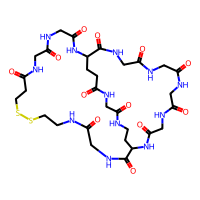
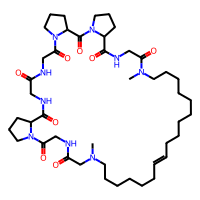
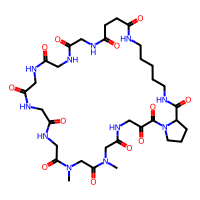
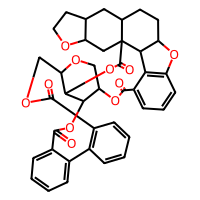

In [144]:
# model is very bad :(
df[df['label'] == 1]